## Installing and Importing some necessary modules

In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb
import riiideducation
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

## Seeding all random parameters for reproducibility

In [2]:
# Random seed
SEED = 123

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(SEED)

## Reading the dataset

In [3]:
df1 = pd.read_feather('../input/riiid-feature-engineering-1-3-correct/riiid_train1.feather')
df2 = pd.read_feather('../input/riiid-feature-engineering-2-3-correct/riiid_train2.feather')
df = pd.concat([df1,df2], axis = 0)
df.reset_index(drop = True, inplace = True)
del df1, df2

In [4]:
train = df.iloc[:50000000]
valid = df.iloc[50000000:]
del df
gc.collect()

20

In [5]:
# train = pd.read_feather('../input/riiid-feature-engineering-2-3-correct/riiid_train2.feather').iloc[:20000000].reset_index(drop = True)
# valid = pd.read_feather('../input/riiid-feature-engineering-2-3-correct/riiid_train2.feather').iloc[20000000:].reset_index(drop = True)

In [6]:
train.reset_index(drop = True, inplace = True)
valid.reset_index(drop = True, inplace = True)

Splitting training dataset into train and validation sets. Then extracting meaningful features for training

In [7]:
TARGET = 'answered_correctly'

FEATURES = ['prior_question_elapsed_time', 'prior_question_had_explanation', 'answered_correctly_u_avg',
        'explanation_u_avg', 'part', 'community',
       'answered_correctly_q_avg', 'explanation_q_avg', 'elapsed_time_q_avg',
       'timestamp_u_recency_1', 'timestamp_u_recency_2',
       'timestamp_u_recency_3', 'timestamp_u_incorrect_recency',
       'num_lectures', 'num_0', 'num_1', 'num_2', 'num_3',
       'answered_correctly_uq_count']

# Shuffle
train = train.sample(40000000, random_state = SEED)
gc.collect()

drop_cols = list(set(train.columns) - set(FEATURES))
y_train = train[TARGET]
y_val = valid[TARGET]
# Drop unnecessary columns
train = train[FEATURES]
valid = valid[FEATURES]
gc.collect()

lgb_train = lgb.Dataset(train[FEATURES], y_train, categorical_feature = [4, 5])
lgb_valid = lgb.Dataset(valid[FEATURES], y_val, categorical_feature = [4, 5])
del train, y_train, valid, y_val
gc.collect()

0

# Light Gradient Boosting Machine

Creating LGBM model with some parameters and training it with data which was processed above. Assigning **part** and **community** as categorical features. Finally I plotted the feature importance according to lgbm.

Training until validation scores don't improve for 150 rounds
[100]	valid_0's auc: 0.773678
[200]	valid_0's auc: 0.775335
[300]	valid_0's auc: 0.775781
[400]	valid_0's auc: 0.776095
[500]	valid_0's auc: 0.776344
[600]	valid_0's auc: 0.776464
[700]	valid_0's auc: 0.7766
[800]	valid_0's auc: 0.77671
[900]	valid_0's auc: 0.776756
[1000]	valid_0's auc: 0.776811
[1100]	valid_0's auc: 0.776865
[1200]	valid_0's auc: 0.776892
[1300]	valid_0's auc: 0.776926
[1400]	valid_0's auc: 0.776952
[1500]	valid_0's auc: 0.776981
[1600]	valid_0's auc: 0.777014
[1700]	valid_0's auc: 0.77702
[1800]	valid_0's auc: 0.77704
[1900]	valid_0's auc: 0.777046
[2000]	valid_0's auc: 0.777064
[2100]	valid_0's auc: 0.77706
Early stopping, best iteration is:
[2012]	valid_0's auc: 0.777067


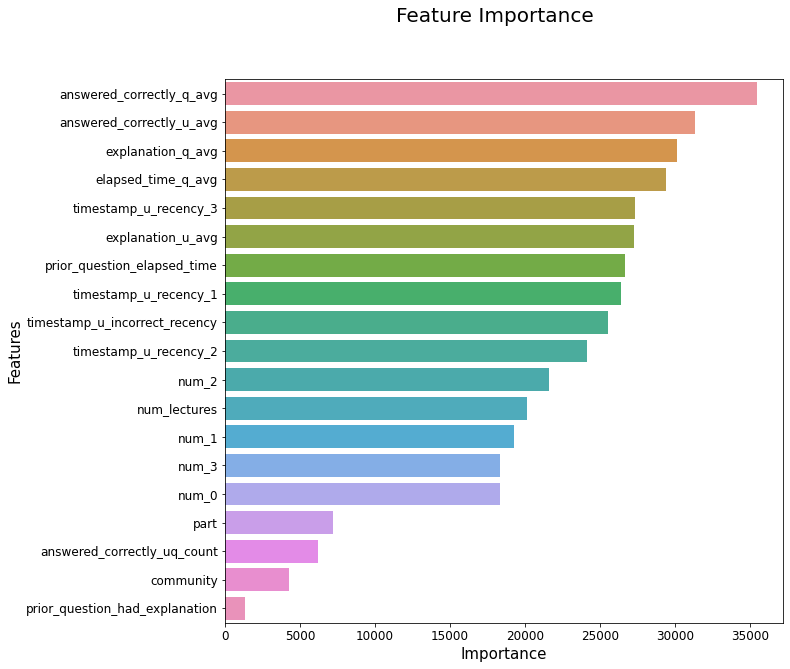

CPU times: user 8h 49min 33s, sys: 4min 7s, total: 8h 53min 41s
Wall time: 2h 28min 2s


In [8]:
%%time
params = {'objective': 'binary', 
          'seed': SEED,
          'metric': 'auc',
          'num_leaves': 200,
          'feature_fraction': 0.75,
          'bagging_freq': 10,
          'bagging_fraction': 0.80,
         }

model = lgb.train(
    params = params,
    train_set = lgb_train,
    num_boost_round = 3000,
    valid_sets = [lgb_valid],
    categorical_feature = [4, 5],
    early_stopping_rounds = 150,
    verbose_eval = 100,
#     init_model = '../input/lgb-riiid/lgb_loop_30M.txt'
)

feature_importance = model.feature_importance()
feature_importance = pd.DataFrame({'Features': FEATURES, 'Importance': feature_importance}).sort_values('Importance', ascending = False)

fig = plt.figure(figsize = (10, 10))
fig.suptitle('Feature Importance', fontsize = 20)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
sns.barplot(x = feature_importance['Importance'], y = feature_importance['Features'], orient = 'h')
plt.show()
